<center><h1>Assignment 4</h1></center>

In [52]:
# install.packages("gamair")
library(gamair)
# install.packages('lubridate')
library(lubridate)
# install.packages('msm')
library(msm)
# install.packages('mosaic')
library('mosaic')

1. Read the two pages from [Wood (2006)](https://www.dropbox.com/s/g2q2l9lk5w1ccdk/Wood_2006.pdf?dl=1). Using the Hubble data (see code below), answer the following questions.

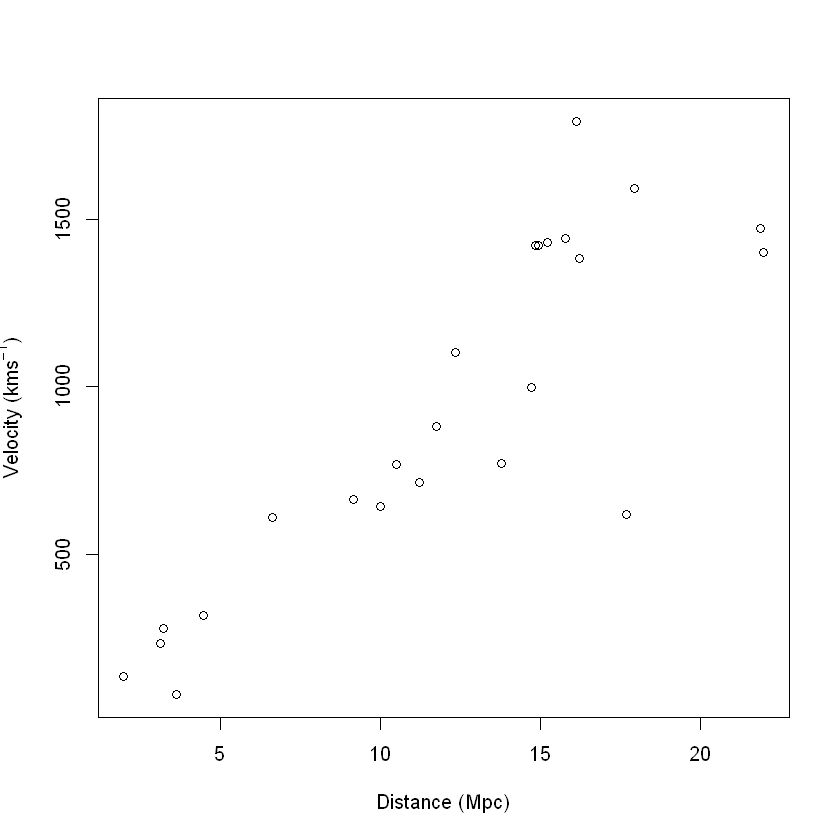

In [53]:
data(hubble)

# Figure 1.1 from Wood 2006
plot(hubble$x,hubble$y,xlab="Distance (Mpc)",
     ylab=expression("Velocity (km"*s^{-1}*")"))

(a) Fit a linear model that corresponds to Hubble's Law. Estimate all parameter(s) using maximum likelihood estimation. Please show all relevant R code.

$y_i = \beta x_i + \epsilon_i$

In [109]:
# 1.
# a.
# y_i = \betax_i + \epsilon_i

x <- hubble$x
y <- hubble$y
n <- length(y)

X <- matrix(data = cbind(rep(1, length(x)), x), nrow = length(x), byrow = FALSE)

beta <- solve(t(X) %*% X) %*% t(X) %*% y
beta

sigma2 <- (1 / n) * t(y - X %*% beta) %*% (y - X %*% beta)
sigma2

6.696255
76.126957


64244.56


(b) Using the parameter estimates from part a, what is the most likely age of the universe in years? Note that distance is measured in Mega parsecs. A Mega parsecs is $3.09x10^{19}$ km.

In [110]:
# b.
ml1 <- lm(y ~ x-1, data = hubble)
beta <- coef(ml1)
beta

mega_parsecs <- 3.09 * 10^19  # in km

distance <- beta / mega_parsecs
distance
age_s <- 1 / distance  # Age of the universe in seconds
age_s

year_in_seconds <- 365 * 24 * 60 * 60
age_y <- age_s / year_in_seconds  # Age of the universe in years
age_y

x 
76.58117

x 
2.478355e-18

x 
4.034934e+17

x 
12794692825

(c) Calculate a 95% confidence interval for the estimated age from part b.

In [111]:
# c.
# Bootstrapping and deltamethod can estimate uncertainy for anything in the model (p-value, R2, CI, etc.)
beta1.hat <- as.numeric(coef(ml1)[1])
beta1.hat

# Get constant
constant <- beta1.hat * age_y
constant

age.se <- deltamethod(~ constant * (1 / x1), mean=coef(ml1), cov=vcov(ml1))

age.ci <- c(
    age_y - 1.96 * age.se,
    age_y + 1.96 * age.se
)
age.ci

[1] 76.58117

x 
979832572298

x           x 
11496364440 14093021210

(d) Explain how to interpret the 95% confidence interval from part c.
- We are 95% confident that the true age (estimated at 12794692825.0865) of the universe falls within the interval of $11496364439.8583$ and $14093021210.3146$.

2. In the R code below, I provide a data set that I obtained from the National Oceanic and Atmospheric Administration (NOAA). The documentation is available here [(link)](https://www.ncei.noaa.gov/data/daily-summaries/doc/GHCND_documentation.pdf). Please write a short 4-5 sentence description of the data (e.g., Where were the data collected? What is being measured?).
   
The Global Historical Climatology Network (GHCN) database serves as the primary data source for this analysis. This database aggregates climate data from 40 meteorological elements, including precipitation, snow depth, daily temperature (maximum and minimum), wind speed, and movement. The data was collected through the cooperation of over 100,000 stations worldwide, making it one of the largest climatological datasets available. The provided R code dataset consists of the following columns:

- STATION
- NAME
- DATE
- TMAX (Maximum daily temperature)
- TMIN (Minimum daily temperature)
- TOBS (Temperature at the time of observation)

Notably, this dataset contains a subset of 47,410 observations from a single location in Manhattan, Kansas, spanning the period from 1893 to 2023.

3. I have always wondered if the temperature in Manhattan has increased over a long time period (i.e., perhaps a local effect of global climate change). Write out a linear model that enables you to determine if the temperature has increased over a long time period. Make sure to explain each component of your linear model and include distributional assumptions (e.g., $\epsilon_i \sim N(0, \sigma^2)$).

- $y_i = \beta_0 + \beta_1t_i + \epsilon_i$
    Where:
    - $y_i$ is the observed temperature at time $t_i$
    - $t_i$ is the time of the observation $i$
    - $\beta_0$ is the intercept of the baseline observed temperature
    - $\beta_1$ is the slope of the change in temperature per unit of time
    - $\epsilon_i$ is the random error term for the observation $i$

Assumptions:
- The TOBS response variable has a linear relationship with the number of days past.
- Residuals follow normal distribution $\epsilon_i \sim N(0, \sigma^2)$


In [57]:
url <- "https://www.dropbox.com/s/asw6gtq7pp1h0bx/manhattan_temp_data.csv?dl=1"
df.temp <- read.csv(url)
df.temp$year <- as.numeric(year(df.temp$DATE))
df.temp$DATE <- ymd(df.temp$DATE)
df.temp$days <- as.numeric(df.temp$DATE - min(df.temp$DATE))

# Cleanup: remove rows with NA TOBS values
df.temp <- subset(df.temp, !is.na(TOBS))
min(df.temp$DATE)

[1] "1901-02-01"

4. For the linear model you wrote out in question 3, estimate and quantify uncertainty for the parameters by fitting this model to the data from question 2. Please write 3-5 sentences explaining your estimates.

In [58]:
# Models TOBS regressed against days.
ml2 <- lm(TOBS ~ days, data=df.temp)

beta0.hat <- as.numeric(coef(ml2)[1])
beta0.hat
beta1.hat <- as.numeric(coef(ml2)[2])
beta1.hat

[1] 46.42983

[1] 0.0001902842

The `intercept` estimate of $46.43$ represents the observed temperature when $x=0$. The `days` estimate represents how for every unit increase in days, the temperature increases by $1.903e-04$ units, or $0.0001903$ degrees.

In [59]:
# Quantify uncertainty for parameters
confint(ml2, level=0.95)

,2.5 %,97.5 %
(Intercept),4.565221e+01,47.207439239
days,1.663215e-04,0.000214247


When using the 95% confidence interval, both intervals cover the estimates:


| Coef. | 2.5 %	| 97.5 % |
| ----  | ----- | ------ |
| (Intercept) |	4.565221e+01 | 47.207439239 |
| days |	1.663215e-04 |	0.000214247 |

This means that the true temperatures from the intercept and days parameters will be covered in the interval 95% of the time.


5. Using the idea of probabilistic thinking and the linear model you used in question 4, predict the temperature for January 1, 2050. Please write 3-5 sentences explaining your prediction.

In [69]:
x <- as.numeric(df.temp$days)
x.bar <- mean(x)
y <- df.temp$TOBS
y.bar <- mean(y)

# Squared distance (with optimization)
sqrd_dist <- optim(
  par = c(0, 0),
  method = c("Nelder-Mead"),
  fn = function(beta) {
    sum((y - (beta[1] + beta[2] * x))^2)
  }
)
sqrd_dist

sqrd_dist_para_1 <- sqrd_dist[1]$par[1]
sqrd_dist_para_2 <- sqrd_dist[1]$par[2]

$par
[1] 4.643207e+01 1.902857e-04

$value
[1] 16241465

$counts
function gradient 
     101       NA 

$convergence
[1] 0

$message
NULL

In [74]:
# Calculate days since start
start_date <- min(ymd(df.temp$DATE))
target_date <- as.Date("2050-01-01")
x_2050 <- as.numeric(target_date - start_date)
x_2050

# squared distance Prediction
tobs_pred_sqrd_dist <- sqrd_dist_para_1 + sqrd_dist_para_2 * x_2050
tobs_pred_sqrd_dist  # 56.7819

Ey.hat_prediction <- predict(ml2, interval="prediction")
tail(Ey.hat_prediction)
Ey.hat_confidence <- predict(ml2, interval="confidence")
tail(Ey.hat_confidence)

[1] 54391

[1] 56.7819

Warning message in predict.lm(ml2, interval = "prediction"):
"predictions on current data refer to _future_ responses
"


,fit,lwr,upr
47405,55.49383,11.70670,99.28095
47406,55.49402,11.70689,99.28114
47407,55.49421,11.70708,99.28133
47408,55.49440,11.70727,99.28152
47409,55.49459,11.70746,99.28171
47410,55.49478,11.70765,99.28190


,fit,lwr,upr
47405,55.49383,55.02367,55.96398
47406,55.49402,55.02384,55.96419
47407,55.49421,55.02401,55.96440
47408,55.49440,55.02418,55.96461
47409,55.49459,55.02435,55.96482
47410,55.49478,55.02452,55.96503


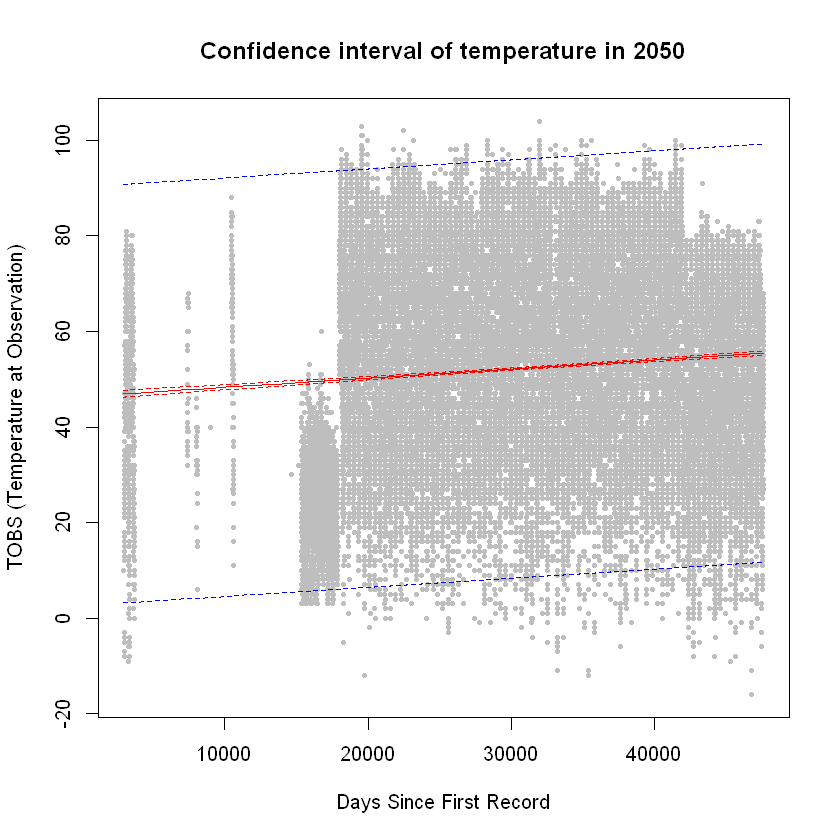

In [68]:
plot(
  x,
  y,
  pch = 16,
  cex = 0.6,
  col = "gray",
  xlab = "Days Since First Record",
  ylab = "TOBS (Temperature at Observation)",
  main = "Confidence interval of temperature in 2050"
)

points(x, Ey.hat_confidence[,1], typ="l", col="red")  # Regression line

points(x, Ey.hat_confidence[,2], typ="l", col="red", lty=2)
points(x, Ey.hat_confidence[,3], typ="l", col="red", lty=2)
points(x, Ey.hat_prediction[,2], typ="l", col="blue", lty=2)
points(x, Ey.hat_prediction[,3], typ="l", col="blue", lty=2)

In [79]:
x_2050_df <- data.frame(days=x_2050)
predict(ml2, newdata = x_2050_df, interval = "prediction")

,fit,lwr,upr
1,56.77958,12.99067,100.5685


I used optimized squared distance to predict the observed temperature as $56.7819$ on January 1st, 2050. When observing the confidence intervals for the last 6 rows of the dataset, we can see that the fitted value is around $55$ at $47410$ days, which gives some indication that a temperature of $56$ is possible in 2050. In fact, we can say we are 95% confident that the true observed temperature on January, 1st 2050 is $56$ degrees. The prediction intervals indicate that the estimate has a 95% probability of being any value between the interval bounds.

When we predict the temperature for January 1st, 2050 using the fitted model, we can see that the fitted value is $56.77958$. However, the lower and upper bounds are wide, at $12.99067$ and $100.5685$ respectively. Despite this, it could be possible that the predicted TOBS on Jan 1st could be any value between those two bounds, but we would expect a temperature of $56$ degrees to be observed.

6. Using the idea of probabilistic thinking how much has the temperature changed in the past 100 years (i.e., between the dates of January 1, 1924 to January 1, 2024)? Please write 3-5 sentences explaining your results.

In [107]:
start_date <- min(ymd(df.temp$DATE))
date_1924 <- as.Date("1924-01-01")
date_2024 <- as.Date("2024-01-01")
x_1924 <- as.numeric(date_1924 - start_date)
x_2024 <- as.numeric(date_2024 - start_date)

# squared distance prediction
tobs_1924 <- sqrd_dist_para_1 + sqrd_dist_para_2 * x_1924
tobs_1924  # 48.0245749166632
tobs_2024 <- sqrd_dist_para_1 + sqrd_dist_para_2 * x_2024
tobs_2024 # 54.9747594215703

print("Difference:")
tobs_2024 - tobs_1924

[1] 48.02457

[1] 54.97476

[1] "Difference:"


[1] 6.950185

In [108]:
# model prediction
x_1924_df <- data.frame(days = x_1924)
pred_1924 <- predict(ml2, newdata = x_1924_df, interval = "prediction", level = 0.95)
pred_1924

x_2024_df <- data.frame(days = x_2024)
pred_2024 <- predict(ml2, newdata = x_2024_df, interval = "prediction", level = 0.95)
pred_2024

print("Differences:")
pred_2024[1,]["fit"] - pred_1924[1,]["fit"]
pred_2024[1,]["lwr"] - pred_1924[1,]["lwr"]
pred_2024[1,]["upr"] - pred_1924[1,]["upr"]

,fit,lwr,upr
1,48.02231,4.233737,91.81089


,fit,lwr,upr
1,54.97245,11.18588,98.75901


[1] "Differences:"


fit 
6.950132

lwr 
6.952142

upr 
6.948121

Using the plot and calculations above, we can see that there is an increasing trend in temperature over the past 100 years and more. Using the squared distance prediction, I estimated that the observed temperature on January 1st, 1924 was about $48$ degrees while the observed temperature on January 1st, 2024 was about $54$, with a difference of about $6.95$. Further, when using the model prediction of the temperature differences between 1924 and 2024, we see similar results. The prediction interval for 1924 shows a lower bound of $4.23$ and an upper bound of $91.81$, with the fitted value being $48.02$. The prediction interval for 2024 shows a lower bound of $54.97$ and an upper bound of $98.76$, with the fitted value being $54.97$. When taking the differences for all three, we see that the average temperature difference is $6.95$, about the same when using the squared distance prediction.

Given all of the statistics calculated, it is very likely that the temperature is increasing over time.

7. The linear model used to answer questions requires the use of data and assumptions to enable estimation, prediction, and statistical inference. Write a list that contains all known assumptions about the data and the model that are required to obtain reliable estimation, prediction, and statistical inference. For each item on your list provide a short (e.g., 1 sentence) explanation of the assumption.

- Linearity: We assume there to be a linear relationship between the response and predictor variables, indicating the directionality and strength of the relationship.
- Homoscedasticity: We assume that the residuals to have constant variance across all the predictor variables.
- Normality: We assume that the residuals are normally distributed ($\epsilon \sim N(0, \sigma^2)$).
- Independence of Errors: We expect the residuals to be independent of each other.
- No Multicollinearity: We assume that the predictor variables are not highly correlated with each other.